In [1]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")
using LinearAlgebra, Optim, Measures, CSV, DataFrames, Plots

In [2]:
ω_c = 5e-1
ω_q = 3e-1
N = 6
amp_c = 1
amp_q = 1
T = 1

1

In [3]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
annihilation = annihilation_operator(N)
sp = [0 1; 0 0]
sm = [0 0; 1 0]
sz = [1 0; 0 -1]
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)

12×12 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [4]:
function cost_no_coupling(sz, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c, N)

  prop_qubit = Matrix(I,2,2)
  prop_cavity = Matrix(I,N,N)
  amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
  amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

  # time ordered product of the single exponential matrices
  # is this true at all? or we need more time steps aniway?
  for l in 0:δt:T
      H_c = amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag) + ω_c * adag * a
      H_q = amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + ω_q * sz/2
      prop_cavity = cis(- H_c * δt) * prop_cavity
  end

  c = tr(unitary' * kron(prop_cavity, prop_qubit))/(N*2)
 
  return 1 - norm(c)^2
end

function gate_no_coupling(sz, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c, N)

  prop_qubit = Matrix(I,2,2)
  prop_cavity = Matrix(I,N,N)
  amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
  amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

  # time ordered product of the single exponential matrices
  # is this true at all? or we need more time steps aniway?
  for l in 0:δt:T
      H_c = amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)+ ω_c * adag * a
      H_q = amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + ω_q * sz/2
      prop_cavity = cis(- H_c * δt) * prop_cavity
  end

  kron(prop_cavity, prop_qubit)

end

gate_no_coupling (generic function with 1 method)

In [9]:
f(x) = cost_no_coupling(sz, sp, sm, annihilation, annihilation', T, T / (100) , x, X_gate, ω_c, ω_q, 1e-3, 1e-3, N)
g(x) = gate_no_coupling(sz, sp, sm, annihilation, annihilation', T, T / (100) , x, X_gate, ω_c, ω_q, 1e-2, 1e-2, N)

g (generic function with 1 method)

In [10]:
it_costs_x = []
coefficients_x = []
for iteration in 1:1
    coefficients = rand(36)*2 .-1 + (rand(36)*2im .-1im)
    println(" iterations :", iteration)
    res_x = Optim.optimize(f, coefficients , LBFGS(), Optim.Options(show_trace=true, show_every=10,iterations=100))
    push!(it_costs_x,Optim.minimum(res_x))
    push!(coefficients_x,Optim.minimizer(res_x))
end

 iterations :1
Iter     Function value   Gradient norm 


     0     8.821246e-01     1.028720e-06
 * time: 9.799003601074219e-5


    10     6.684727e-01     1.552305e-04
 * time: 4.525774002075195


    20     5.759652e-01     1.028895e-04
 * time: 7.459479093551636


    30     5.608785e-01     1.584819e-05
 * time: 10.65272307395935


    40     4.729838e-01     3.810024e-05
 * time: 13.757769107818604


    50     3.543402e-01     5.818237e-05
 * time: 16.487941026687622


    60     1.767894e-01     1.130996e-04
 * time: 19.109375


    70     1.551494e-01     2.612088e-05
 * time: 22.004010915756226


    80     1.463825e-01     8.432213e-06
 * time: 25.003891944885254


    90     1.377302e-01     6.894991e-06
 * time: 27.78860092163086


   100     1.283774e-01     1.143897e-05
 * time: 30.728806972503662


In [12]:
heatmap(imag(g(coefficients_x[1])))
coefficients_x[1]

36-element Vector{ComplexF64}:
  -465.84199665797087 + 1803.5149176935756im
  -1577.0737348276211 - 596.8767665681881im
  -1484.0713494918443 + 5770.932648266968im
  -1061.8699967025557 - 752.4717016050935im
    695.3909656966786 - 3652.280752909302im
    962.6600257048966 + 2996.9849007448074im
   -2233.007611056442 + 1099.563098652052im
   1394.1506593093652 + 286.9321338855943im
     3646.60277038329 - 953.8213664950938im
   1282.5035333530234 - 2652.190312249889im
                      ⋮
  -0.7654590672042827 - 0.9314022617255528im
   0.6512608257522241 - 0.16136656179905073im
 0.016077950540813735 + 0.9554517417545887im
 -0.15071541993664517 - 0.9349485875661814im
 -0.19608941558450854 + 0.17780561258957195im
  -0.8084916397269435 - 0.027624803493793815im
   0.8733357477935455 + 0.8683265437018679im
  -0.2628635914496813 + 0.6771910451860994im
  0.15755350717650085 + 0.24357073533738838im

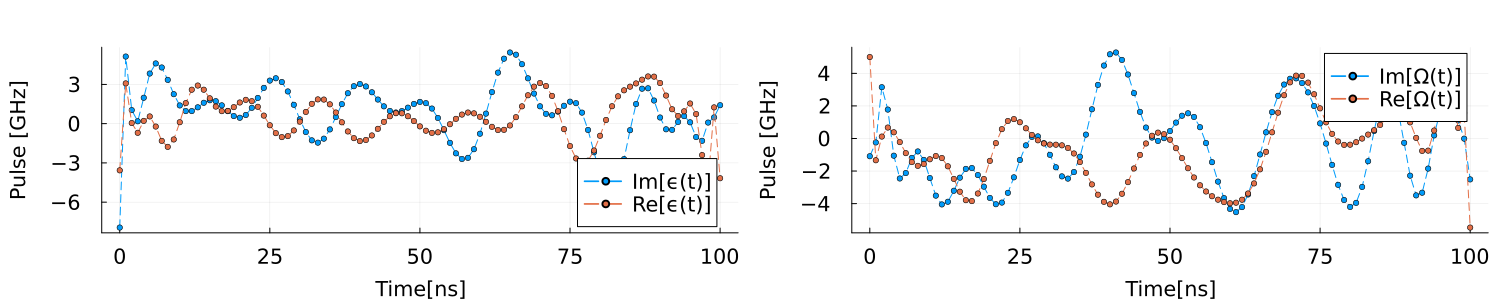

In [45]:
coeffs_cavity = coefficients_x[1][1:26]
coeffs_qubit = coefficients_x[1][27:end]
d=1
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*d, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*d, t)

amps_c = [amplitude_c(l)/d for l in 0:T*d/(100):T*d]
amps_q = [amplitude_q(l)/d for l in 0:T*d/(100):T*d]

imaginary_part = plot([l for l in 0:T*d /100:T*d], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(1500,300), margin=10mm,xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /100:T*d], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*d /100:T*d], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /100:T*d], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)